In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
import scipy.stats as stats
from sklearn.linear_model import lars_path

sns.set()
%matplotlib inline

In [145]:
#plt.style.use('dark_background')

In [146]:
global_random_state = 15

**Read the cleaned data and delete our unused index**

In [147]:
batters_df = pd.read_csv('DEA Notebooks/cleaned_batting_years_1985_to_2017.csv')

In [148]:
del batters_df['Unnamed: 0']

In [149]:
batters_df.columns

Index(['ID', 'NAME', 'HEIGHT', 'WEIGHT', 'YEAR', 'AGE', 'TM', 'LG', 'G', 'PA',
       'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'AWARDS', 'SALARY', 'BATS_Left', 'BATS_Right', 'LG_SALARY_YEAR',
       'LG_SALARY_MEAN', 'POS_1', 'POS_2', 'POS_3', 'POS_4', 'POS_5', 'POS_6',
       'POS_7', 'POS_8', 'POS_9', 'POS_D', 'LG_MEAN_HR'],
      dtype='object')

**Let's create candidate features to run correlation plots against salary**

In [150]:
batting_features_1 = ['H', 'R', 'BB', '2B', '3B', 'HR', 'TB', 'RBI']
batting_features_2 = ['BA', 'OBP', 'SLG', 'OPS']
other_offense_features = ['SB','GDP','CS','IBB', 'HBP']

frequency_features = ['AB','PA','G']

physical_features = ['HEIGHT', 'WEIGHT', 'BATS_Left', 'BATS_Right']


**Only look at starting players, skip the strike shortened season, and leave out outlier seasons**

In [151]:

subset_to_test_with = batters_df[(batters_df.PA >= 400) & (batters_df.YEAR != 1994) & (batters_df.BB < 170)]
subset_to_test_with.is_copy = False

subset_to_test_with.shape

(6337, 49)

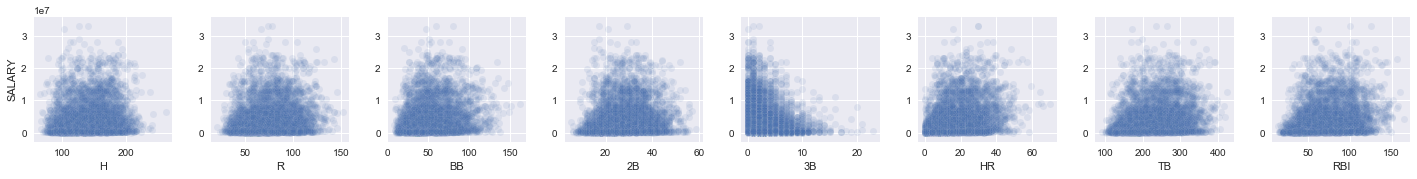

In [152]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'],
                    x_vars=batting_features_1, plot_kws={'alpha': 0.1})

H, 2B, 3B, and HR are all colinear in some ways. Doubles, triples, and HRs are all also hits. RBI and HR are also semi co-linear since home runs increase RBIs by at least 1 (and more if runners are on the bases)

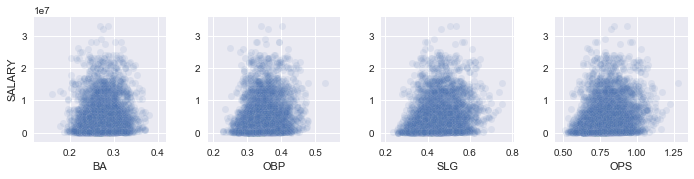

In [153]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'], 
                    x_vars=batting_features_2, plot_kws ={'alpha': 0.1})

All 4 of these stats have colinear relationships. OBP increases as BA increases, BA is involved in SLG, and OPS is OBP + SLG. All 4 plots look basically the same, so if we're only going to use one going forward, we'll use OPS

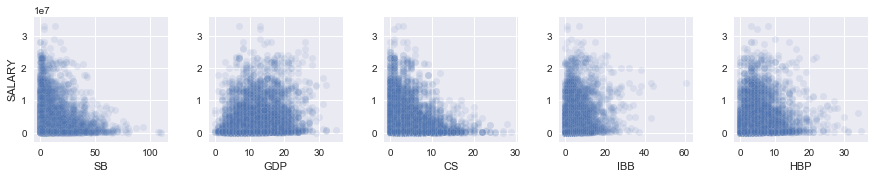

In [154]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'],
                    x_vars=other_offense_features, plot_kws ={'alpha': 0.1})

My main takeaway: It doesn't pay to steal (in baseball)

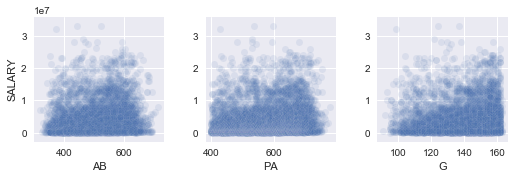

In [155]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'],
                    x_vars=frequency_features, plot_kws ={'alpha': 0.1})

High earners play more games. Makes sense.

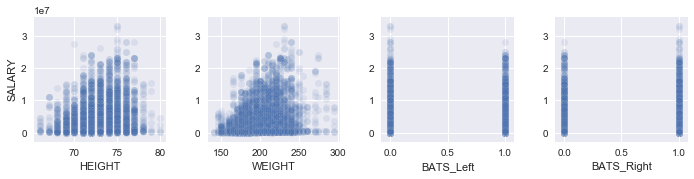

In [156]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'],
                    x_vars=physical_features, plot_kws ={'alpha': 0.1})


Takeaways from the above scatterplots: Nothing is really linear. Lots of 'normal' looking distributions with curvature, so polynomial variables will most likely help with modeling.

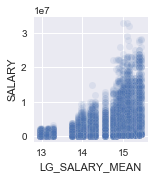

In [157]:
pair = sns.pairplot(subset_to_test_with, y_vars=['SALARY'],
                    x_vars=['LG_SALARY_MEAN'], plot_kws ={'alpha': 0.1})

**Let's look at the distribution of our target variable: Salary**

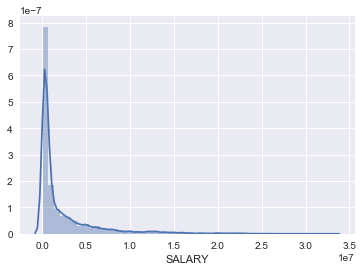

In [158]:
sns.distplot(batters_df['SALARY'])

There's a prominent positive skew to this distribution. Since we're looking for ballpark estimates on salaries, apply a log function to the distributon in order to estimate magnittude

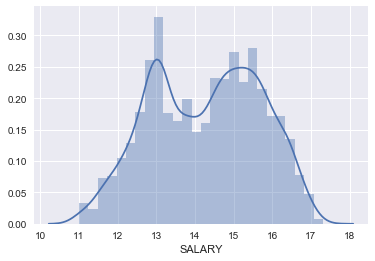

In [159]:
y_value_to_test = np.log(subset_to_test_with['SALARY'])

sns.distplot(y_value_to_test)

# Minimum Viable Product #

None of our statistics showed incredible strong correlation with salary. Given that, I'll use my domain knowledge of baseball offensive stats and use OPS for our first model.

In [160]:

def run_models(features, target, alpha=None, show_diagnostic_plots=False, poly_features=None):
    y = np.asarray(target)
    X = np.asarray(subset_to_test_with[features])

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=global_random_state)

    kf = KFold(n_splits=5, shuffle=True, random_state = global_random_state)
    
    linear_models = [LinearRegression()]
    if alpha is not None:
        linear_models.append(Ridge(alpha=alpha))
        linear_models.append(Lasso(alpha=alpha))
    
    for linear_model in linear_models:

        train_scores = []
        train_errors = []
        
        for train_ind, val_ind in kf.split(X,y):
            X_train, y_train = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind] 
            
            
            if poly_features:
                X_train_scaled = poly_features.fit_transform(X_train)
                X_val_scaled = poly_features.transform(X_val)
            else:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                
            linear_model.fit(X_train_scaled, y_train)
            
            valid_set_pred = linear_model.predict(X_val_scaled)
            train_scores.append(linear_model.score(X_val_scaled, y_val))
            train_errors.append(np.sqrt(np.mean((valid_set_pred - y_val)**2)))
            #coefs.append(list(zip(features_to_test, linear_model.coef_)))
        
        print('Model: {}'.format(linear_model))    
        print('Mean R^2: {}'.format(np.mean(train_scores)))
        print('Mean RMSE: {}'.format(np.mean(train_errors)))
        
        if show_diagnostic_plots:
            diagnostic_plot(X,y)
        
        
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    s = len(y)
    rgr = LinearRegression()
    pred = None
    # We can only do prediction line plot for 1D input
    if x.shape[1] == 1:
        rgr.fit(x.reshape(s,1),y)
        pred = rgr.predict(x.reshape(s,1))
    else:
        rgr.fit(x,y)
        pred = rgr.predict(x)
        
    if x.shape[1] == 1:
        plt.subplot(1, 3, 1)
        plt.scatter(x,y)
        plt.plot(x, pred, color='blue',linewidth=1)
        plt.title("Regression fit")
        plt.xlabel("x")
        plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean R^2: 0.06827851844515302
Mean RMSE: 1.3638914954270012


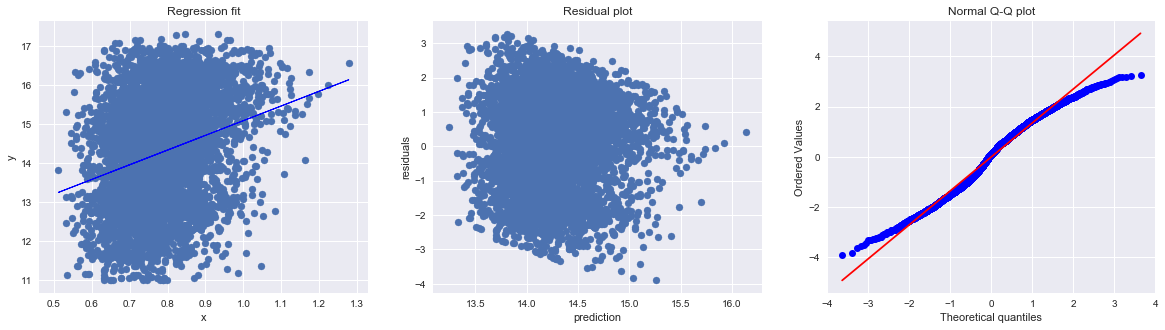

In [161]:
features_to_test = ['OPS']
run_models(features_to_test, y_value_to_test, show_diagnostic_plots=True)

Not great. Once again, using domain knowledge, I know that player value in general in baseball has exploded in the last 30 year, so let's include the mean salary for each stat season. Let's add AGE and LG_SALARY_MEAN and see if things improve. Also, since we've already seen that our distributions are all curved, let's apply polynomial features

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean R^2: 0.6144691866824173
Mean RMSE: 0.8771285604750805


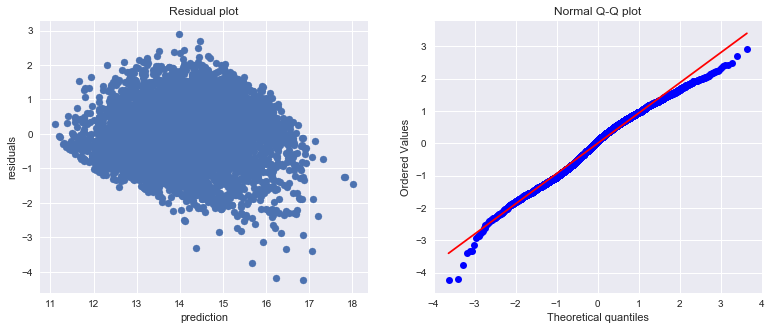

In [162]:
features_to_test = ['OPS', 'AGE', 'LG_SALARY_MEAN']
poly_features = PolynomialFeatures(degree=2) 
run_models(features_to_test, y_value_to_test, show_diagnostic_plots=True, poly_features=poly_features)

Much better! Our Q-Q plot looks a bit tighter now. The residual plot is a bit tough to interpret since so many aspects of our dataset are tightly bound between upper and lower bounds (such as Age and OPS).

# SM.OLS statistics #

Let's take a look at the results in statsmodule OLS

In [163]:
def run_OLS(features, target, poly_features=None):
    y = np.asarray(target)
    X = np.asarray(subset_to_test_with[features])

    X, _, y, _ = train_test_split(X, y, test_size=.2, random_state=global_random_state)
    
    if poly_features:
        X_train_scaled = poly_features.fit_transform(X) 
        features = poly_features.get_feature_names(features)
        #0, 4 , 5
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X)
    
    model = sm.OLS(y,sm.add_constant(X_train_scaled))
    model.data.xnames = features
    fit = model.fit()
    return fit


In [164]:
fit = run_OLS(features_to_test, y_value_to_test, poly_features)

fit.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>            <td>y</td>        <th>  R-squared:         </th> <td>   0.616</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.616</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   902.7</td> 
</tr>
<tr>
  <th>Date:</th>             <td>Sun, 04 Feb 2018</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>10:21:01</td>     <th>  Log-Likelihood:    </th> <td> -6518.6</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  5069</td>      <th>  AIC:               </th> <td>1.306e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  5059</td>      <th>  BIC:               </th> <td>1.312e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     9</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
           <td></td>             <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>1</th>                  <td>   18.7182</td> <td>    5.454</td> <td>    3.432</td> <td> 0.001</td> <td>    8.025</td> <td>   29.411</td>
</tr>
<tr>
  <th>OPS</th>                <td>   -2.3051</td> <td>    2.772</td> <td>   -0.832</td> <td> 0.406</td> <td>   -7.739</td> <td>    3.129</td>
</tr>
<tr>
  <th>AGE</th>                <td>    0.7461</td> <td>    0.071</td> <td>   10.451</td> <td> 0.000</td> <td>    0.606</td> <td>    0.886</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN</th>     <td>   -3.3875</td> <td>    0.709</td> <td>   -4.777</td> <td> 0.000</td> <td>   -4.778</td> <td>   -1.997</td>
</tr>
<tr>
  <th>OPS^2</th>              <td>    4.7358</td> <td>    0.848</td> <td>    5.585</td> <td> 0.000</td> <td>    3.073</td> <td>    6.398</td>
</tr>
<tr>
  <th>OPS AGE</th>            <td>   -0.0430</td> <td>    0.032</td> <td>   -1.323</td> <td> 0.186</td> <td>   -0.107</td> <td>    0.021</td>
</tr>
<tr>
  <th>OPS LG_SALARY_MEAN</th> <td>   -0.0865</td> <td>    0.171</td> <td>   -0.506</td> <td> 0.613</td> <td>   -0.422</td> <td>    0.249</td>
</tr>
<tr>
  <th>AGE^2</th>              <td>   -0.0159</td> <td>    0.001</td> <td>  -25.320</td> <td> 0.000</td> <td>   -0.017</td> <td>   -0.015</td>
</tr>
<tr>
  <th>AGE LG_SALARY_MEAN</th> <td>    0.0294</td> <td>    0.004</td> <td>    7.441</td> <td> 0.000</td> <td>    0.022</td> <td>    0.037</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN^2</th>   <td>    0.1191</td> <td>    0.025</td> <td>    4.846</td> <td> 0.000</td> <td>    0.071</td> <td>    0.167</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>60.916</td> <th>  Durbin-Watson:     </th> <td>   1.993</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td>  62.922</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.271</td> <th>  Prob(JB):          </th> <td>2.17e-14</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 2.937</td> <th>  Cond. No.          </th> <td>4.53e+05</td>
</tr>
</table>

# LARS Path #
Next, let's test the features we have now against some other features in a LARS path to see which ones zero out faster than the others (leaving out polynomials for now)

In [165]:
def create_LARS_path_chart(features, target, poly_features=None, save_chart=False):
    y = np.asarray(target)
    X = np.asarray(subset_to_test_with[features])

    X, _, y, _ = train_test_split(X, y, test_size=.2, random_state=global_random_state)
    
    if poly_features:
        X = poly_features.fit_transform(X)
        features = poly_features.get_feature_names(features)
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    alphas, _, coefs = lars_path(X, y, method='lasso', verbose=True)
    
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    
    plt.figure(figsize=(10,10))
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.legend(features)
    
    if save_chart:
        file_name = '|'.join(features)
        plt.savefig('LARS_path_' + file_name + '.png')
        
    plt.show()
    

.

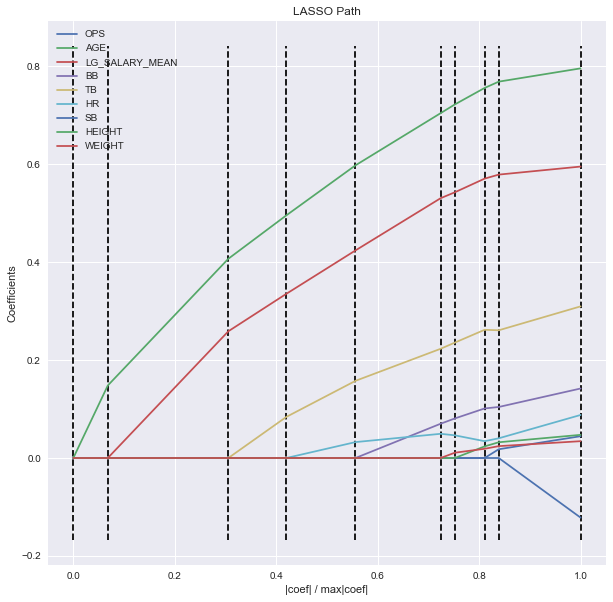

In [166]:
other_features_to_test = ['BB', 'TB', 'HR', 'SB', 'HEIGHT', 'WEIGHT']
create_LARS_path_chart(features_to_test + other_features_to_test,y_value_to_test, save_chart=True)

Surprisingly we see that Total Bases has a stronger effect on the model than OPS. OPS includes total based data (in the SLG portion), but it also includes walking rates. Let's look at the model with TB instead of OPS

In [167]:

fit = run_OLS(['TB', 'AGE', 'LG_SALARY_MEAN'], y_value_to_test, poly_features)

fit.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>            <td>y</td>        <th>  R-squared:         </th> <td>   0.640</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.639</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   999.2</td> 
</tr>
<tr>
  <th>Date:</th>             <td>Sun, 04 Feb 2018</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>10:21:02</td>     <th>  Log-Likelihood:    </th> <td> -6357.0</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  5069</td>      <th>  AIC:               </th> <td>1.273e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  5059</td>      <th>  BIC:               </th> <td>1.280e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     9</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
           <td></td>             <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>1</th>                  <td>   13.8381</td> <td>    5.062</td> <td>    2.734</td> <td> 0.006</td> <td>    3.914</td> <td>   23.762</td>
</tr>
<tr>
  <th>TB</th>                 <td>    0.0041</td> <td>    0.004</td> <td>    0.908</td> <td> 0.364</td> <td>   -0.005</td> <td>    0.013</td>
</tr>
<tr>
  <th>AGE</th>                <td>    0.6888</td> <td>    0.068</td> <td>   10.194</td> <td> 0.000</td> <td>    0.556</td> <td>    0.821</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN</th>     <td>   -2.7196</td> <td>    0.679</td> <td>   -4.007</td> <td> 0.000</td> <td>   -4.050</td> <td>   -1.389</td>
</tr>
<tr>
  <th>TB^2</th>               <td> 5.945e-06</td> <td> 3.06e-06</td> <td>    1.945</td> <td> 0.052</td> <td>-4.87e-08</td> <td> 1.19e-05</td>
</tr>
<tr>
  <th>TB AGE</th>             <td> 1.166e-05</td> <td> 5.56e-05</td> <td>    0.210</td> <td> 0.834</td> <td>-9.74e-05</td> <td>    0.000</td>
</tr>
<tr>
  <th>TB LG_SALARY_MEAN</th>  <td>-5.345e-05</td> <td>    0.000</td> <td>   -0.187</td> <td> 0.852</td> <td>   -0.001</td> <td>    0.001</td>
</tr>
<tr>
  <th>AGE^2</th>              <td>   -0.0155</td> <td>    0.001</td> <td>  -25.477</td> <td> 0.000</td> <td>   -0.017</td> <td>   -0.014</td>
</tr>
<tr>
  <th>AGE LG_SALARY_MEAN</th> <td>    0.0301</td> <td>    0.004</td> <td>    7.822</td> <td> 0.000</td> <td>    0.023</td> <td>    0.038</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN^2</th>   <td>    0.0924</td> <td>    0.024</td> <td>    3.904</td> <td> 0.000</td> <td>    0.046</td> <td>    0.139</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>46.323</td> <th>  Durbin-Watson:     </th> <td>   1.997</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td>  47.403</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.236</td> <th>  Prob(JB):          </th> <td>5.09e-11</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 3.030</td> <th>  Cond. No.          </th> <td>2.54e+07</td>
</tr>
</table>

Comparing the two OLS tables, the pvalues for interactions between OPS/TBS and the other attributes are both less than ideal. TB<sup>2</sup> and OPSTB<sup>2</sup> both have acceptable pvalues though. Given all this, we'll use TB in our model, but only as TB<sup>2</sup>

# Regularization #
One final bit of work before we create our final mode. Let's see if regularization can help our model with polynomial features:

In [168]:
def find_alpha(features, target, poly_features=None):
    y = np.asarray(target)
    X = np.asarray(subset_to_test_with[features])

    X, _, y, _ = train_test_split(X, y, test_size=.2, random_state=global_random_state)
    
    params = {
        "alpha": np.logspace(-4, 2, 20)
    }
    
    if poly_features:
        X = poly_features.fit_transform(X)
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    grid_est = GridSearchCV(Lasso(), param_grid=params, cv=5)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.grid_scores_)
    df["alpha"] = df.parameters.apply(lambda val: val["alpha"])
    plt.plot(np.log(df.alpha), df.mean_validation_score);
    return grid_est.grid_scores_

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.61387, std: 0.01027, params: {'alpha': 0.0001},
 mean: 0.61373, std: 0.01034, params: {'alpha': 0.00020691380811147902},
 mean: 0.61337, std: 0.01046, params: {'alpha': 0.00042813323987193956},
 mean: 0.61216, std: 0.01072, params: {'alpha': 0.00088586679041008235},
 mean: 0.61065, std: 0.01083, params: {'alpha': 0.0018329807108324356},
 mean: 0.61032, std: 0.01077, params: {'alpha': 0.0037926901907322499},
 mean: 0.60920, std: 0.01072, params: {'alpha': 0.0078475997035146062},
 mean: 0.60638, std: 0.01121, params: {'alpha': 0.01623776739188721},
 mean: 0.60236, std: 0.01158, params: {'alpha': 0.033598182862837812},
 mean: 0.60190, std: 0.01162, params: {'alpha': 0.069519279617756058},
 mean: 0.59991, std: 0.01172, params: {'alpha': 0.14384498882876628},
 mean: 0.59134, std: 0.01191, params: {'alpha': 0.29763514416313164},
 mean: 0.56348, std: 0.01188, params: {'alpha': 0.61584821106602605},
 mean: 0.54192, std: 0.01132, params: {'alpha': 1.2742749857031321},
 mean: 0.53424, s

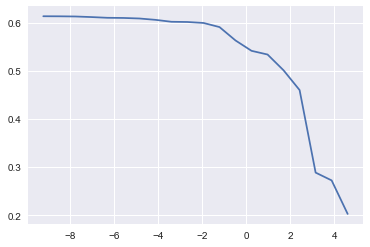

In [169]:
find_alpha(features_to_test, y_value_to_test, poly_features=poly_features)

Regularization doesn't appear to help our prediction score, so we will not use it in our final model

# Putting it all together #
Our main features will be Age, mean salary for the year the statline was recorded, total bases, and polynomial combinations of those.

In [170]:
def create_df_with_useful_polynomials(df):
    # We want
    # Age
    # LG_SALARY_MEAN
    # TB**2
    # AGE**2
    # AGE * LG_SALARY_MEAN
    # LG_SALARY_MEAN**2
    df['TB**2'] = df['TB']**2
    df['AGE**2'] = df['AGE']**2
    df['AGE*LG_SALARY_MEAN'] = df['AGE'] * df['LG_SALARY_MEAN']
    df['LG_SALARY_MEAN**2'] = df['LG_SALARY_MEAN']**2
    columns = ['AGE', 'LG_SALARY_MEAN', 'TB**2', 'AGE**2', 'AGE*LG_SALARY_MEAN',
               'LG_SALARY_MEAN**2']
    return df[columns]


In [171]:
subset_to_test_with = create_df_with_useful_polynomials(subset_to_test_with)

subset_to_test_with.head(5)

,AGE,LG_SALARY_MEAN,TB**2,AGE**2,AGE*LG_SALARY_MEAN,LG_SALARY_MEAN**2
7317,25.0,15.006978,27556.0,625.0,375.174445,225.209383
7318,28.0,15.006978,22201.0,784.0,420.195379,225.209383
7319,25.0,15.107826,18769.0,625.0,377.695654,228.246412
7320,41.0,12.994703,17956.0,1681.0,532.782814,168.862300
7321,26.0,13.274325,13456.0,676.0,345.132456,176.207711


In [172]:
features_to_test = ['AGE', 'LG_SALARY_MEAN', 'TB**2', 'AGE**2', 'AGE*LG_SALARY_MEAN',
               'LG_SALARY_MEAN**2']
fit = run_OLS(features_to_test, y_value_to_test)

fit.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>            <td>y</td>        <th>  R-squared:         </th> <td>   0.639</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.639</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   1497.</td> 
</tr>
<tr>
  <th>Date:</th>             <td>Sun, 04 Feb 2018</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>10:21:05</td>     <th>  Log-Likelihood:    </th> <td> -6360.4</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  5069</td>      <th>  AIC:               </th> <td>1.273e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  5062</td>      <th>  BIC:               </th> <td>1.278e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     6</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
           <td></td>             <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>AGE</th>                <td>   14.2621</td> <td>    0.012</td> <td> 1195.771</td> <td> 0.000</td> <td>   14.239</td> <td>   14.286</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN</th>     <td>    2.7249</td> <td>    0.263</td> <td>   10.363</td> <td> 0.000</td> <td>    2.209</td> <td>    3.240</td>
</tr>
<tr>
  <th>TB**2</th>              <td>   -2.1806</td> <td>    0.531</td> <td>   -4.110</td> <td> 0.000</td> <td>   -3.221</td> <td>   -1.140</td>
</tr>
<tr>
  <th>AGE**2</th>             <td>    0.3624</td> <td>    0.012</td> <td>   30.116</td> <td> 0.000</td> <td>    0.339</td> <td>    0.386</td>
</tr>
<tr>
  <th>AGE*LG_SALARY_MEAN</th> <td>   -3.6523</td> <td>    0.142</td> <td>  -25.632</td> <td> 0.000</td> <td>   -3.932</td> <td>   -3.373</td>
</tr>
<tr>
  <th>LG_SALARY_MEAN**2</th>  <td>    1.8658</td> <td>    0.236</td> <td>    7.900</td> <td> 0.000</td> <td>    1.403</td> <td>    2.329</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>45.701</td> <th>  Durbin-Watson:     </th> <td>   1.998</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td>  46.751</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.235</td> <th>  Prob(JB):          </th> <td>7.05e-11</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 3.029</td> <th>  Cond. No.          </th> <td>    109.</td>
</tr>
</table>

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean R^2: 0.63833813335532
Mean RMSE: 0.8494088958811243


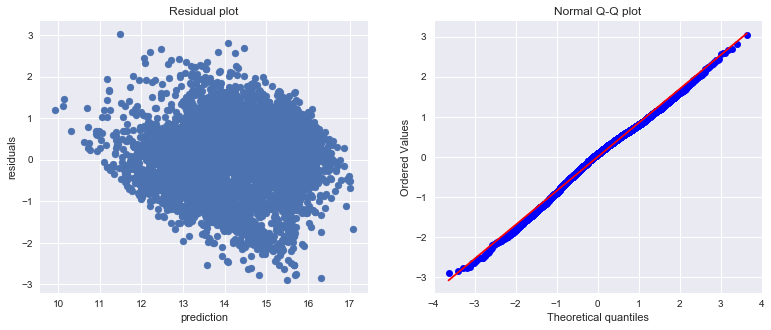

In [173]:
run_models(features_to_test, y_value_to_test, show_diagnostic_plots=True)

In [174]:
def run_final_model(features, target):
    
    y = np.asarray(target)
    X = np.asarray(subset_to_test_with[features])

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=global_random_state)
    lr = LinearRegression()
        
    
    lr.fit(X, y)
    
    test_pred_y = lr.predict(X_test)
    
    print(lr.score(X_test, y_test))

In [175]:
run_final_model(features_to_test, y_value_to_test)

0.638620470031


In [176]:
#the_list = list(zip(features_to_test, lr.coef_))
#for item in the_list:
#    print ('{}: {:.3f}'.format(item[0], item[1]))

#lr.coef_